In [1]:
import os
image_path = "../dataset/pizza_steak_sushi/"

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

In [2]:
from torchvision import transforms
from data_setup import createDataloader

train_transform = transforms.Compose(
    [   
        transforms.Resize((224, 224)) ,
        transforms.ToTensor()

    ]
)

train_DL, test_DL, _classes = createDataloader(train_dir, test_dir, 32, train_transform, train_transform )

In [3]:
len(train_DL)

71

In [4]:
_classes

['pizza', 'steak', 'sushi']

14


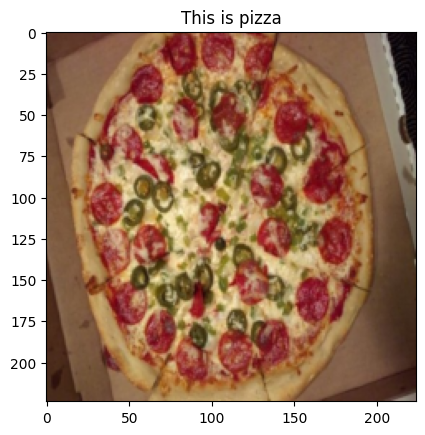

In [5]:
# data visuals
import  matplotlib.pyplot as plt
from PIL import Image
import random

img, lable = next(iter(test_DL))

rand_id = random.randint(0,31)
print(rand_id)

show_img = img[rand_id]
plt.title("This is {}".format(_classes[lable[rand_id]]))
plt.imshow(show_img.permute(1,2,0))

# Replicating ViT

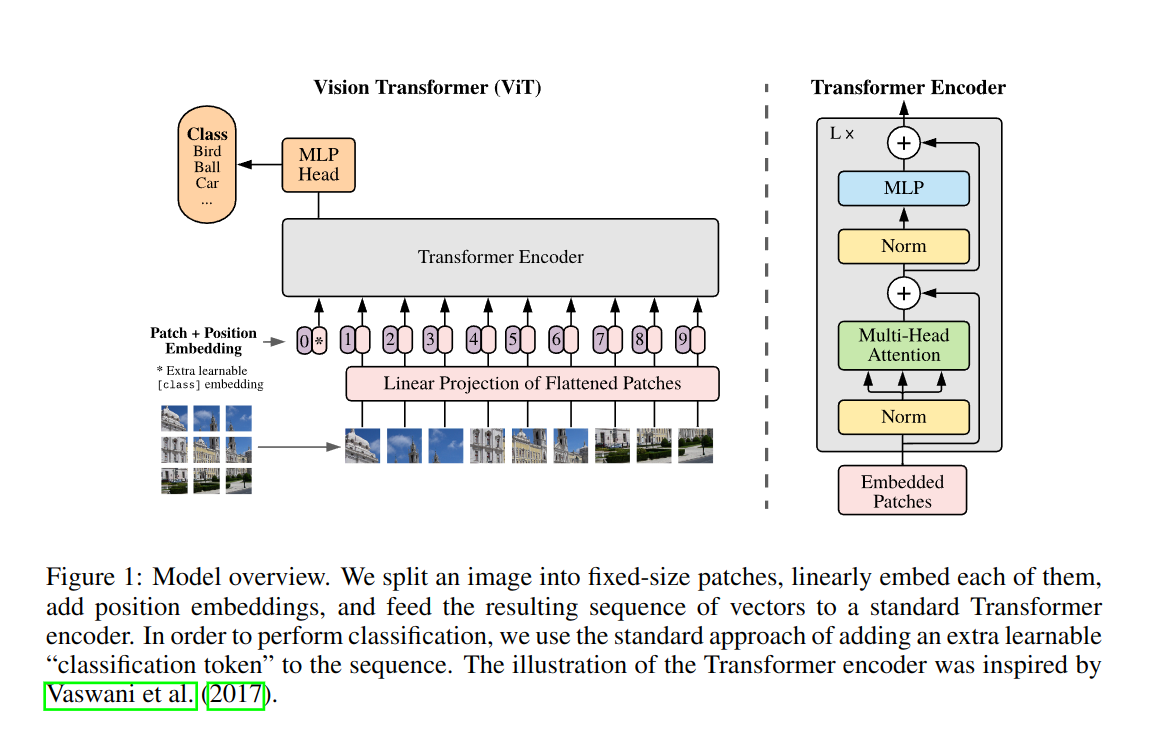

### Embedding - Leaning representations, start from a random initialization and improve them through training.
    - 1D vector will be input to the model


##### * Equation 1
```python
x_input = [class_token, image_patch1, image_patch2,.. image_patchN] + [class_token_pos, image_patch1_pos, image_patch2_pos,.. image_patchN_pos]
```

##### * Equation 2
```python
x_MSA_output = MultiHSA(LayerNorm(x_input)) + x_input
```

##### * Equation 3
```python
x_MLP_output = MLP(LayerNorm(x_MSA_output)) + x_MSA_output
```

<b>MLP - Multi Layer Perceptron (a nn with multiple layers)</b>

##### Equation 4 - Output
```python
x_output = LinearLayer(LayerNorm(x_MLP_output))
```

## Patch position and class Embeding

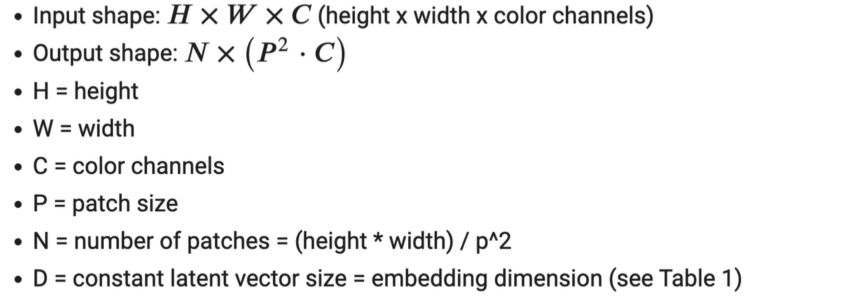

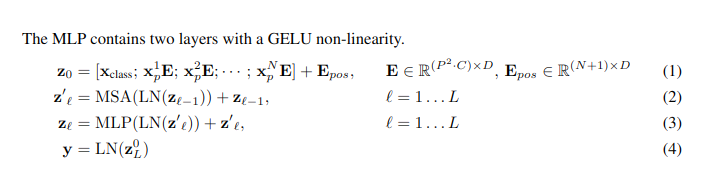

In [6]:
H = 224
W = 224
C = 3
P = 16
N = int((H * W) / P**2)
N

196

In [7]:
#adding

# EQ 1. Patch Embbeding with Positional Encoding
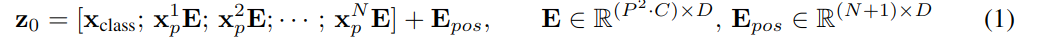

In [22]:
# compliling eq.1 in a single block of code
import torch
from torch import nn

single_img = next(iter(test_DL))[0][0].unsqueeze(0) # single img of batch 1

# patch embb code
class PatchEmbeddingWithPosEmbb(nn.Module):
    def __init__(self, color_channel, out_num_patch, patch_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels=color_channel, 
                               out_channels=out_num_patch,
                               kernel_size=patch_size,
                               stride=patch_size, 
                               padding=0)
        self.flat = nn.Flatten(start_dim=2, end_dim=3)
    
    # Class Token (B, 1, embedding_token) concat to Patched image (B, no_of_patches, embedding_token) = (B, 1+no_of_patches, embedding_token)
    def class_token(self, patch_embb):
        class_token_layer = nn.Parameter(torch.randn(patch_embb.shape[0], 1, patch_embb.shape[2]), requires_grad=True) # (B, 1, 768)
        return torch.cat((class_token_layer, patch_embb),dim=1)
    
    # Adding Patched Embb with Class Token - (B, 1+no_of_patches, Emmbed_dim)
    def position_embbeding(self, patch_embb):
        pos_embb_layer = nn.Parameter(torch.ones(patch_embb.shape), requires_grad=True) 
        return torch.add(patch_embb, pos_embb_layer) # (B, 196, 768) + (B, 196, 768) 

    def forward(self, x):
        x = self.conv_layer(x) # Patched Imgae - (batch, C, H, W) --> (Batch, no_of_patches, embedding_dim patches)
        x = self.flat(x).permute(0,2,1)
        x = self.class_token(x)
        return self.position_embbeding(x)
    
pe = PatchEmbeddingWithPosEmbb(3, 768, 16)
input_patch_embedding = pe(img)
print(input_patch_embedding.shape)

torch.Size([32, 197, 768])


# EQ 2. Multi Head Self Attention with Layer Normalization with previous output


In [39]:
layer_norm = nn.LayerNorm(normalized_shape=input_patch_embedding.shape)
layer_norm_embb = layer_norm(input_patch_embedding)
multi_head = nn.MultiheadAttention(embed_dim=768, num_heads=6)
atten, _ = multi_head(query=layer_norm_embb, key=layer_norm_embb, value=layer_norm_embb, need_weights=True)
atten.shape

torch.Size([32, 197, 768])

In [41]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embb_dim: int, num_heads: int, attn_dropout: 0):
        super().__init__()
        
        # layernorm
        self.layer_norm = nn.LayerNorm(normalized_shape=embb_dim)
        
        # multi head, we have (B, NumPatch, EmbedDim) or (B, Seq, Feat)
        self.multiHead = nn.MultiheadAttention(embed_dim=embb_dim, num_heads=num_heads, dropout=attn_dropout, batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        atten_out, _ = self.multiHead(query=x, key=x, value=x,need_weights=False)
        return atten_out


In [42]:
MSA = MultiheadSelfAttention(embb_dim=768, num_heads=12, attn_dropout=0)
MSA(input_patch_embedding).shape

torch.Size([32, 197, 768])